In [41]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import copy
 
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#모델

In [42]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_emb, trg_emb, fc_layer):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_emb = src_emb
        self.trg_emb = trg_emb
        self.fc_layer = fc_layer

    def forward(self, input_tensor, target_tensor, input_mask, target_mask):
        context = self.encode(input_tensor, input_mask)
        out = self.decode(target_tensor, target_mask, context, input_mask)
        out = self.fc_layer(out)
        out = F.log_softmax(out, dim=-1)
        out=out.squeeze()
        return out

    def encode(self, x, mask):
        out = self.encoder(self.src_emb(x), mask)
        return out
    
    def decode(self, x, mask, encoder_output, encoder_mask):
        out = self.decoder(self.trg_emb(x), mask, encoder_output, encoder_mask)
        return out

In [43]:
class Encoder(nn.Module):
    def __init__(self, n_layers, layers):
        super().__init__()
        self.layers = []
        for l in range(n_layers):
            self.layers.append(copy.deepcopy(layers))

    def forward(self, x, mask):
        out = x
        for layer in self.layers:
            out = layer(out, mask)
        return out

In [44]:
class EncoderLayer(nn.Module):
    def __init__(self, attn_layer, ff_layer, norm):
        super().__init__()
        self.attn_layer = attn_layer
        self.ff_layer = ff_layer
        self.norm = norm

    def forward(self, x, mask):
        out = self.attn_layer(x, x, x, mask)
        out = x + out
        out = self.norm(out)
        
        out_ = self.ff_layer(out)
        out = out + out_
        out = self.norm(out)
        return out

In [45]:
class Decoder(nn.Module):
    def __init__(self, n_layers, layers):
        super().__init__()
        self.layers = []
        for l in range(n_layers):
            self.layers.append(copy.deepcopy(layers))

    def forward(self, x, mask, encoder_output, encoder_mask):
        out = x
        for layer in self.layers:
            out = layer(out, mask, encoder_output, encoder_mask)
        return out

In [46]:
class DecoderLayer(nn.Module):
    def __init__(self, masked_attn_layer, attn_layer, ff_layer, norm):
        super().__init__()
        self.masked_attn_layer = masked_attn_layer
        self.attn_layer = attn_layer
        self.ff_layer = ff_layer
        self.norm = norm

    def forward(self, x, mask, encoder_output, encoder_mask):
        out = self.masked_attn_layer(x, x, x, mask)
        out = x + out
        out = self.norm(out)

        out_ = self.attn_layer(out, encoder_output, encoder_output, encoder_mask)
        out = out + out_
        out = self.norm(out)

        out_ = self.ff_layer(out)
        out = out + out_
        out = self.norm(out)
        return out

In [47]:
class PositionEncoding(nn.Module):
    def __init__(self, d_embed, dropout_p, max_len = 4000):
        super().__init__()
        encoding = torch.zeros(max_len, d_embed)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_embed, 2) * -(math.log(10000.0)/ d_embed))
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        encoding = encoding.unsqueeze(0)
        self.encoding = encoding
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        out = x + Variable(self.encoding[:, :x.size(1)], requires_grad=False).to(device)
        out = self.dropout(out)
        return out

In [48]:
class MultiHeadAttn(nn.Module):
    def __init__(self, d_model, n_head, qkv_fc_layer, fc_layer, dropout_p):
        super().__init__()
        self.d_model = d_model
        self.n_head = n_head
        self.q_fc = copy.deepcopy(qkv_fc_layer)
        self.k_fc = copy.deepcopy(qkv_fc_layer)
        self.v_fc = copy.deepcopy(qkv_fc_layer)
        self.fc_layer = fc_layer
        self.dropout = nn.Dropout(dropout_p)

    def calcAttn(self, q, k, v, mask, dropout=None):
        dk = k.size(-1)
        score = torch.matmul(q, k.transpose(-2, -1))
        score = score / math.sqrt(d_k)
        if mask is not None:
            score = score.masked_fill(mask==0, -1e9)
        out = F.softmax(score, dim=-1)
        if dropout is not None:
            out = dropout(out)
        out = torch.matmul(out, v)
        return out

    def forward(self, q, k, v, mask=None):
        n_batch = q.shape[0]
        
        def transform(x, fc_layer):
            out = fc_layer(x)
            out = out.view(n_batch, -1, self.n_head, self.d_model//self.n_head)
            out = out.transpose(1, 2)
            return out
        
        q = transform(q, self.q_fc)
        k = transform(k, self.k_fc)
        v = transform(v, self.v_fc)
        if mask is not None:
            mask = mask.unsqueeze(1)

        out = self.calcAttn(q, k, v, mask, self.dropout)
        out = out.transpose(1, 2)
        out = out.contiguous().view(n_batch, -1, self.d_model)
        out = self.fc_layer(out)
        return out

In [49]:
class Feedforward(nn.Module):
    def __init__(self, first, second, dropout_p):
        super().__init__()
        self.first = first
        self.second = second
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        out = self.first(x)
        out = F.relu(x)
        out = self.dropout(out)
        out = self.second(out)
        return out

In [50]:
class Embedding(nn.Module):
    def __init__(self, d_embed, vocab):
        super(Embedding, self).__init__()
        self.embedding = nn.Embedding(len(vocab), d_embed)
        self.vocab = vocab
        self.d_embed = d_embed
    
    def forward(self, x):
        out = self.embedding(x) * math.sqrt(self.d_embed)
        return out

In [51]:
class TransformerEmbedding(nn.Module):
    def __init__(self, embedding, positional_encoding):
        super(TransformerEmbedding, self).__init__()
        self.embedding = nn.Sequential(embedding, positional_encoding)
    
    def forward(self, x):
        out = self.embedding(x)
        return out

In [52]:

def make_model(
    src_vocab, 
    trg_vocab, 
    d_embed = 512, 
    n_layer = 6, 
    d_model = 512, 
    n_head = 8, 
    d_ff = 512,
    dropout_p = 0.1):

    cp = lambda x : copy.deepcopy(x).to(device)

    multi_head_attention_layer = MultiHeadAttn(
                                    d_model = d_model,
                                    n_head = n_head,
                                    qkv_fc_layer = nn.Linear(d_embed, d_model),
                                    fc_layer = nn.Linear(d_model, d_embed),
                                    dropout_p = dropout_p)
    
    position_wise_feed_forward_layer = Feedforward(
                                         first = nn.Linear(d_embed, d_ff),
                                         second = nn.Linear(d_ff, d_embed),
                                         dropout_p = dropout_p)
    
    norm_layer = nn.LayerNorm(d_embed, eps=1e-6)

    model = Transformer(
                src_emb = TransformerEmbedding(
                                embedding = Embedding(
                                                d_embed = d_embed, 
                                                vocab = src_vocab).to(device), 
                                positional_encoding = PositionEncoding(
                                                d_embed = d_embed,
                                                dropout_p = dropout_p).to(device)), 
                trg_emb = TransformerEmbedding(
                                embedding = Embedding(
                                                d_embed = d_embed, 
                                                vocab = trg_vocab).to(device), 
                                positional_encoding = PositionEncoding(
                                                d_embed = d_embed,
                                                dropout_p = dropout_p).to(device)),
                encoder = Encoder(
                                layers = EncoderLayer(
                                                attn_layer = cp(multi_head_attention_layer),
                                                ff_layer = cp(position_wise_feed_forward_layer),
                                                norm = cp(norm_layer)),
                                n_layers = n_layer),
                decoder = Decoder(
                                layers = DecoderLayer(
                                                masked_attn_layer = cp(multi_head_attention_layer),
                                                attn_layer = cp(multi_head_attention_layer),
                                                ff_layer = cp(position_wise_feed_forward_layer),
                                                norm = cp(norm_layer)),
                                n_layers = n_layer),
                fc_layer = nn.Linear(d_model, len(trg_vocab)).to(device))
    
    return model

# 전처리


In [53]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
    
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [54]:
tr_e = open('/content/drive/MyDrive/ColabFiles/wmt16/train.en').read().strip().split('\n')
tr_d = open('/content/drive/MyDrive/ColabFiles/wmt16/train.de').read().strip().split('\n')
te_e = open('/content/drive/MyDrive/ColabFiles/wmt16/test.en').read().strip().split('\n')
te_d = open('/content/drive/MyDrive/ColabFiles/wmt16/test.de').read().strip().split('\n')
va_e = open('/content/drive/MyDrive/ColabFiles/wmt16/val.en').read().strip().split('\n')
va_d = open('/content/drive/MyDrive/ColabFiles/wmt16/val.de').read().strip().split('\n')


In [55]:
print(te_e, te_d)
print(va_e, va_d)

['A man in an orange hat starring at something.', 'A Boston Terrier is running on lush green grass in front of a white fence.', 'A girl in karate uniform breaking a stick with a front kick.', 'Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.', 'People are fixing the roof of a house.', 'A man in light colored clothing photographs a group of men wearing dark suits and hats standing around a woman dressed in a strapless gown.', 'A group of people standing in front of an igloo.', 'A boy in a red uniform is attempting to avoid getting out at home plate, while the catcher in the blue uniform is attempting to catch him.', 'A guy works on a building.', 'A man in a vest is sitting in a chair and holding magazines.', 'A mother and her young song enjoying a beautiful day outside.', 'Men playing volleyball, with one player missing the ball but hands still in the air.', 'A woman holding a bowl of food in a kitchen.', 'Man sitting using tool at a 

In [56]:
tr_e = [normalizeString(s) for s in tr_e]
tr_d = [normalizeString(s) for s in tr_d]
te_e = [normalizeString(s) for s in te_e]
te_d = [normalizeString(s) for s in te_d]
va_e = [normalizeString(s) for s in va_e]
va_d = [normalizeString(s) for s in va_d]

In [57]:
print(te_e, te_d)
print(va_e, va_d)

['a man in an orange hat starring at something .', 'a boston terrier is running on lush green grass in front of a white fence .', 'a girl in karate uniform breaking a stick with a front kick .', 'five people wearing winter jackets and helmets stand in the snow with snowmobiles in the background .', 'people are fixing the roof of a house .', 'a man in light colored clothing photographs a group of men wearing dark suits and hats standing around a woman dressed in a strapless gown .', 'a group of people standing in front of an igloo .', 'a boy in a red uniform is attempting to avoid getting out at home plate while the catcher in the blue uniform is attempting to catch him .', 'a guy works on a building .', 'a man in a vest is sitting in a chair and holding magazines .', 'a mother and her young song enjoying a beautiful day outside .', 'men playing volleyball with one player missing the ball but hands still in the air .', 'a woman holding a bowl of food in a kitchen .', 'man sitting using 

In [58]:
SOS_token = 0
EOS_token = 1
PAD_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "PAD"}
        self.n_words = 3  # SOS 와 EOS PAD 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [59]:
MAX_LENGTH = 0

for sen in tr_e:
    if len(sen.split()) > MAX_LENGTH:
        MAX_LENGTH = len(sen.split())

for sen in tr_d:
    if len(sen.split()) > MAX_LENGTH:
        MAX_LENGTH = len(sen.split())

for sen in te_e:
    if len(sen.split()) > MAX_LENGTH:
        MAX_LENGTH = len(sen.split())

for sen in te_d:
    if len(sen.split()) > MAX_LENGTH:
        MAX_LENGTH = len(sen.split())

for sen in va_e:
    if len(sen.split()) > MAX_LENGTH:
        MAX_LENGTH = len(sen.split())

for sen in va_d:
    if len(sen.split()) > MAX_LENGTH:
        MAX_LENGTH = len(sen.split())

In [60]:
lang_e = Lang('e')
lang_d = Lang('d')

In [61]:
pair_tr=[]
for i in range(len(tr_e)):
    pair_tr.append((tr_d[i], tr_e[i]))

pair_te=[]
for i in range(len(te_e)):
    pair_te.append((te_d[i], te_e[i]))

pair_va=[]
for i in range(len(va_e)):
    pair_va.append((va_d[i], va_e[i]))

In [62]:
for pair in pair_tr:
    lang_d.addSentence(pair[0])
    lang_e.addSentence(pair[1])

for pair in pair_te:
    lang_d.addSentence(pair[0])
    lang_e.addSentence(pair[1])

for pair in pair_va:
    lang_d.addSentence(pair[0])
    lang_e.addSentence(pair[1])

In [63]:
print(lang_e.n_words)
print(lang_d.n_words)

9980
18295


In [64]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(lang_d, pair[0])
    target_tensor = tensorFromSentence(lang_e, pair[1])
    return (input_tensor, target_tensor)

#Trainer

In [65]:
class Batch:
    def __init__(self, src, trg=None, pad=3):
        self.src = src.T
        self.src_mask = (self.src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg.T[:, :-1]
            self.trg_y = trg.T[:,1:]
            self.trg_mask = self.make_mask(self.trg, pad)
            self.lengths = torch.sum((self.trg_y != pad),dim=1)
            self.ntokens = (self.trg_y != pad).data.sum()

    def __len__(self):
        return len(self.src)

    def subsequent_mask(self, size):
        attn_shape = (1, size, size)
        mask = np.triu(np.ones(attn_shape), k = 1).astype('uint8')
        return torch.from_numpy(mask) == 0

    def make_mask(self, trg, pad):
        trg_mask = (trg != pad).unsqueeze(-2)
        trg_mask = trg_mask & Variable(self.subsequent_mask(trg.size(-1)).type_as(trg_mask.data))
        return trg_mask

In [66]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [67]:
def trainIters(model, 
               criterion,
               optimizer,
               n_iters,
               print_every=1000,
               plot_every=100):
    start = time.time()
    plot_loss = []
    print_loss_total = 0
    plot_loss_total = 0

    training_pairs = [tensorsFromPair(random.choice(pair_tr)) 
    for iter in range(1, n_iters+1)]
    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        batch = Batch(input_tensor, target_tensor)

        batch.src = batch.src.to(device)
        batch.trg = batch.trg.to(device)
        batch.src_mask = batch.src_mask.to(device)
        batch.trg_mask = batch.trg_mask.to(device)

        loss = train(batch.src, batch.trg, batch.src_mask, batch.trg_mask, model, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_loss.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_loss

In [68]:
def train(input_tensor, target_tensor, input_mask, target_mask, model, optimizer, criterion):
    loss = 0
    optimizer.zero_grad()
    outputs = model(input_tensor, target_tensor, input_mask, target_mask)
    loss = criterion(outputs, target_tensor.contiguous().view(-1))
    loss.backward()
    optimizer.step()
    return loss.item()/tgt_len

In [69]:
MAX_LENGTH = 32

src_vocab_size = lang_d.n_words
tgt_vocab_size = lang_e.n_words

src_len = MAX_LENGTH
tgt_len = MAX_LENGTH+1

d_model = 512
d_ff = 2048
d_k = d_v = 64
n_layers = 6
n_heads = 8

model = make_model(lang_d.index2word.values(), lang_e.index2word.values())
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losslist = trainIters(model, criterion, optimizer, n_iters=10000)

0m 34s (- 5m 9s) (1000 10%) 0.1025
1m 6s (- 4m 27s) (2000 20%) 0.0450
1m 40s (- 3m 54s) (3000 30%) 0.0334
2m 13s (- 3m 19s) (4000 40%) 0.0249
2m 47s (- 2m 47s) (5000 50%) 0.0215
3m 19s (- 2m 13s) (6000 60%) 0.0174
3m 53s (- 1m 40s) (7000 70%) 0.0168
4m 25s (- 1m 6s) (8000 80%) 0.0157
4m 59s (- 0m 33s) (9000 90%) 0.0113
5m 33s (- 0m 0s) (10000 100%) 0.0126


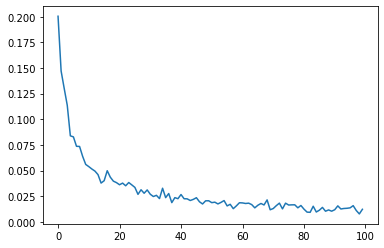

In [70]:
import matplotlib.pyplot as plt

plt.plot(losslist)

#TEST

In [71]:
from nltk.translate.bleu_score import sentence_bleu

In [72]:
def embToWord(sentence, lang):
    wordlist=[]
    for word in sentence:
        wordlist.append(
            lang.index2word[torch.argmax(word).item()]
            )
    return wordlist

In [73]:
def test(model):
    testcorpus = []
    test_pairs = []
    targetcorpus = []

    for i in range(0, len(pair_te)):
        test_pairs.append(tensorsFromPair(pair_te[i]))
    for iter in range(0, len(pair_te)):
        test_pair = test_pairs[iter]
        input_tensor = test_pair[0]
        target_tensor = test_pair[1]

        batch = Batch(input_tensor, target_tensor)

        batch.src = batch.src.to(device)
        batch.trg = batch.trg.to(device)
        batch.src_mask = batch.src_mask.to(device)
        batch.trg_mask = batch.trg_mask.to(device)
        testcorpus.append(
            embToWord(model(batch.src, batch.trg, batch.src_mask, batch.trg_mask), lang_e)
            )
        targetcorpus.append(te_e[iter].split())
    return testcorpus, targetcorpus


In [74]:
testcorpus, targetcorpus = test(model)

In [75]:
score = 0
cnt = 0
for i in range(len(testcorpus)):
    cnt += 1
    score += sentence_bleu(testcorpus[i], targetcorpus[i])
score /= cnt

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [76]:
score

0.6164856304896983